In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Question 2: Classification Using CNN

### Data Loading and Preprocessing

In [3]:
def load_mnist_data(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label)==1 and int(label) == 0):
                cur_label = 0
            else:
                cur_label = len(label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']



In [4]:
data_path = "./../../data/external/double_mnist"

train_data, train_labels, val_data, val_labels, test_data, test_labels = load_mnist_data(data_path)

In [5]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task = 'classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            
        if (self.task == 'classification'):
            label = torch.tensor(label, dtype=torch.long).to(device)
        elif (self.task == 'regression'):
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### Implement the CNN Class

In [6]:
class CNN(nn.Module):
    def __init__(self, task='classification', num_classes=10):
        super(CNN, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
        return y_pred
    
    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    
    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    


In [7]:
def train(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, y) in train_progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        model.eval()
        total_accuracy = 0
        total_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                total_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y).item()
                
            avg_loss = total_loss / len(val_loader)
            accuracy = total_accuracy / len(val_loader)
            print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")


In [12]:
train_data_classification = MultiMNISTDataset(train_data, train_labels)
val_data_classification = MultiMNISTDataset(val_data, val_labels)
test_data_classification = MultiMNISTDataset(test_data, test_labels)

train_loader_classification = DataLoader(train_data_classification, batch_size=32, shuffle=True)
val_loader_classification = DataLoader(val_data_classification, batch_size=32, shuffle=False)
test_loader_classification = DataLoader(test_data_classification, batch_size=32, shuffle=False)

In [13]:
model = CNN(task='classification', num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader_classification, val_loader_classification, num_epochs=20)

Epoch 1/20: 100%|██████████| 394/394 [00:05<00:00, 72.06it/s, Loss=0.0243]


Epoch 1, Validation Accuracy: 99.14%, Validation Loss: 0.031330


Epoch 2/20: 100%|██████████| 394/394 [00:05<00:00, 75.83it/s, Loss=0.0159]


Epoch 2, Validation Accuracy: 99.30%, Validation Loss: 0.021713


Epoch 3/20: 100%|██████████| 394/394 [00:05<00:00, 75.32it/s, Loss=0.0006]


Epoch 3, Validation Accuracy: 99.70%, Validation Loss: 0.009012


Epoch 4/20: 100%|██████████| 394/394 [00:05<00:00, 75.52it/s, Loss=0.0259]


Epoch 4, Validation Accuracy: 98.39%, Validation Loss: 0.049783


Epoch 5/20: 100%|██████████| 394/394 [00:05<00:00, 75.96it/s, Loss=0.0001]


Epoch 5, Validation Accuracy: 99.70%, Validation Loss: 0.008009


Epoch 6/20: 100%|██████████| 394/394 [00:05<00:00, 75.39it/s, Loss=0.0016]


Epoch 6, Validation Accuracy: 99.66%, Validation Loss: 0.006759


Epoch 7/20: 100%|██████████| 394/394 [00:05<00:00, 74.13it/s, Loss=0.0023]


Epoch 7, Validation Accuracy: 99.72%, Validation Loss: 0.008164


Epoch 8/20: 100%|██████████| 394/394 [00:05<00:00, 75.20it/s, Loss=0.0001]


Epoch 8, Validation Accuracy: 99.93%, Validation Loss: 0.002302


Epoch 9/20: 100%|██████████| 394/394 [00:05<00:00, 72.47it/s, Loss=0.0000]


Epoch 9, Validation Accuracy: 99.87%, Validation Loss: 0.003195


Epoch 10/20: 100%|██████████| 394/394 [00:05<00:00, 74.31it/s, Loss=0.0000]


Epoch 10, Validation Accuracy: 99.90%, Validation Loss: 0.002905


Epoch 11/20: 100%|██████████| 394/394 [00:05<00:00, 74.68it/s, Loss=0.0000]


Epoch 11, Validation Accuracy: 99.90%, Validation Loss: 0.002888


Epoch 12/20: 100%|██████████| 394/394 [00:05<00:00, 74.02it/s, Loss=0.0000]


Epoch 12, Validation Accuracy: 99.90%, Validation Loss: 0.002779


Epoch 13/20: 100%|██████████| 394/394 [00:05<00:00, 72.58it/s, Loss=0.0000]


Epoch 13, Validation Accuracy: 99.90%, Validation Loss: 0.003080


Epoch 14/20: 100%|██████████| 394/394 [00:05<00:00, 72.03it/s, Loss=0.0000]


Epoch 14, Validation Accuracy: 99.90%, Validation Loss: 0.002855


Epoch 15/20: 100%|██████████| 394/394 [00:05<00:00, 68.40it/s, Loss=0.0000]


Epoch 15, Validation Accuracy: 99.90%, Validation Loss: 0.003192


Epoch 16/20: 100%|██████████| 394/394 [00:05<00:00, 72.07it/s, Loss=0.0000]


Epoch 16, Validation Accuracy: 99.90%, Validation Loss: 0.003180


Epoch 17/20: 100%|██████████| 394/394 [00:05<00:00, 75.52it/s, Loss=0.0000]


Epoch 17, Validation Accuracy: 99.90%, Validation Loss: 0.003209


Epoch 18/20: 100%|██████████| 394/394 [00:05<00:00, 67.95it/s, Loss=0.0000]


Epoch 18, Validation Accuracy: 99.90%, Validation Loss: 0.003320


Epoch 19/20: 100%|██████████| 394/394 [00:05<00:00, 68.33it/s, Loss=0.0000]


Epoch 19, Validation Accuracy: 99.90%, Validation Loss: 0.003092


Epoch 20/20: 100%|██████████| 394/394 [00:05<00:00, 69.30it/s, Loss=0.0000]


Epoch 20, Validation Accuracy: 99.90%, Validation Loss: 0.003251


In [14]:
train_data_regression = MultiMNISTDataset(train_data, train_labels, task='regression')
val_data_regression = MultiMNISTDataset(val_data, val_labels, task='regression')
test_data_regression = MultiMNISTDataset(test_data, test_labels, task='regression')

train_loader_regression = DataLoader(train_data_regression, batch_size=32, shuffle=True)
val_loader_regression = DataLoader(val_data_regression, batch_size=32, shuffle=False)
test_loader_regression = DataLoader(test_data_regression, batch_size=32, shuffle=False)

In [15]:
model = CNN(task='regression').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader_regression, val_loader_regression, num_epochs=20)

Epoch 1/20: 100%|██████████| 394/394 [00:05<00:00, 71.52it/s, Loss=0.0534]


Epoch 1, Validation Accuracy: 95.60%, Validation Loss: 0.062031


Epoch 2/20: 100%|██████████| 394/394 [00:05<00:00, 70.78it/s, Loss=0.0410]


Epoch 2, Validation Accuracy: 98.60%, Validation Loss: 0.035381


Epoch 3/20: 100%|██████████| 394/394 [00:05<00:00, 67.07it/s, Loss=0.0375]


Epoch 3, Validation Accuracy: 98.54%, Validation Loss: 0.030522


Epoch 4/20: 100%|██████████| 394/394 [00:05<00:00, 67.26it/s, Loss=0.0226]


Epoch 4, Validation Accuracy: 99.43%, Validation Loss: 0.019130


Epoch 5/20: 100%|██████████| 394/394 [00:05<00:00, 69.37it/s, Loss=0.0123]


Epoch 5, Validation Accuracy: 99.63%, Validation Loss: 0.019339


Epoch 6/20: 100%|██████████| 394/394 [00:05<00:00, 68.62it/s, Loss=0.0109]


Epoch 6, Validation Accuracy: 99.90%, Validation Loss: 0.013377


Epoch 7/20: 100%|██████████| 394/394 [00:05<00:00, 69.99it/s, Loss=0.0110]


Epoch 7, Validation Accuracy: 99.83%, Validation Loss: 0.013101


Epoch 8/20: 100%|██████████| 394/394 [00:05<00:00, 69.25it/s, Loss=0.0077]


Epoch 8, Validation Accuracy: 99.97%, Validation Loss: 0.010760


Epoch 9/20: 100%|██████████| 394/394 [00:05<00:00, 68.26it/s, Loss=0.0056]


Epoch 9, Validation Accuracy: 99.87%, Validation Loss: 0.011205


Epoch 10/20: 100%|██████████| 394/394 [00:05<00:00, 70.16it/s, Loss=0.0089]


Epoch 10, Validation Accuracy: 99.97%, Validation Loss: 0.008936


Epoch 11/20: 100%|██████████| 394/394 [00:05<00:00, 70.43it/s, Loss=0.0112]


Epoch 11, Validation Accuracy: 100.00%, Validation Loss: 0.009595


Epoch 12/20: 100%|██████████| 394/394 [00:05<00:00, 70.25it/s, Loss=0.0064]


Epoch 12, Validation Accuracy: 99.97%, Validation Loss: 0.008230


Epoch 13/20: 100%|██████████| 394/394 [00:05<00:00, 67.71it/s, Loss=0.0056]


Epoch 13, Validation Accuracy: 100.00%, Validation Loss: 0.007196


Epoch 14/20: 100%|██████████| 394/394 [00:05<00:00, 68.46it/s, Loss=0.0102]


Epoch 14, Validation Accuracy: 100.00%, Validation Loss: 0.011089


Epoch 15/20: 100%|██████████| 394/394 [00:05<00:00, 69.46it/s, Loss=0.0039]


Epoch 15, Validation Accuracy: 99.97%, Validation Loss: 0.006012


Epoch 16/20: 100%|██████████| 394/394 [00:05<00:00, 72.04it/s, Loss=0.0039]


Epoch 16, Validation Accuracy: 100.00%, Validation Loss: 0.006552


Epoch 17/20: 100%|██████████| 394/394 [00:05<00:00, 72.69it/s, Loss=0.0028]


Epoch 17, Validation Accuracy: 100.00%, Validation Loss: 0.005867


Epoch 18/20: 100%|██████████| 394/394 [00:05<00:00, 71.76it/s, Loss=0.0019]


Epoch 18, Validation Accuracy: 99.97%, Validation Loss: 0.007442


Epoch 19/20: 100%|██████████| 394/394 [00:11<00:00, 35.17it/s, Loss=0.0081]


Epoch 19, Validation Accuracy: 100.00%, Validation Loss: 0.005142


Epoch 20/20: 100%|██████████| 394/394 [00:09<00:00, 41.24it/s, Loss=0.0019]


Epoch 20, Validation Accuracy: 100.00%, Validation Loss: 0.006104


In [16]:
def load_mnist_data_multilabel(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label) == 1 and int(label) == 0):
                cur_label = []
            else:
                cur_label = [int(i) for i in label]
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [17]:
def get_one_hot(y):
    one_hot = np.zeros(33)
    if len(y) == 0:
        y.append(10)
        y.append(10)
        y.append(10)
    elif len(y) == 1:
        y.append(10)
        y.append(10)
    elif len(y) == 2:
        y.append(10)
    for i in range(len(y)):
        one_hot[y[i]+10*i+i] = 1
    return one_hot

In [18]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


In [19]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label



class CNN_Multilabel(nn.Module):
    def __init__(self, task='multilabel_classification', num_classes=33):
        super(CNN_Multilabel, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred_labels = self.convert_to_labels(y_pred)
            y_true_labels = self.convert_to_labels(y_true)
            accuracy = 0
            for i in range(len(y_pred_labels)):
                flag = 1
                if len(y_pred_labels[i]) == len(y_true_labels[i]):
                    for j in range(len(y_pred_labels[i])):
                        if y_pred_labels[i][j] != y_true_labels[i][j]:
                            flag = 0
                            break
                else:
                    flag = 0
                accuracy += flag
            return accuracy/len(y_pred_labels)
        else:
            return F.mse_loss(y_pred, y_true)


    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            criterion = nn.CrossEntropyLoss()
            loss = 0
            for i in range(3):
                start = i * 11
                end = (i + 1) * 11
                target_idx = torch.argmax(y_true[:, start:end], dim=1)
                loss += criterion(y_pred[:, start:end], target_idx)
            return loss
        else:
            return F.mse_loss(y_pred, y_true)
            
    def convert_to_labels(self, y_pred):
        labels = []
        batch_size = y_pred.shape[0]
        for i in range(batch_size):
            label = []
            for j in range(3):
                start = j * 11
                end = (j + 1) * 11
                cur_label = torch.argmax(y_pred[i, start:end]).item()
                if cur_label != 10:
                    label.append(cur_label)
                else:
                    break
            labels.append(label)
        return labels

In [20]:
def train_multilabel(model, optimizer, train_loader, val_loader, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, y) in train_progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        model.eval()
        total_accuracy = 0
        total_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                total_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y)

            avg_loss = total_loss / len(val_loader)
            accuracy = total_accuracy / len(val_loader)
            print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")


In [21]:
train_data_multilabel, train_labels_multilabel, val_data_multilabel, val_labels_multilabel, test_data_multilabel, test_labels_multilabel = load_mnist_data_multilabel(data_path)

In [22]:
train_labels_multilabel_one_hot = [get_one_hot(y) for y in train_labels_multilabel]
val_labels_multilabel_one_hot = [get_one_hot(y) for y in val_labels_multilabel]
test_labels_multilabel_one_hot = [get_one_hot(y) for y in test_labels_multilabel]

In [23]:

train_data_multilabel = MultiMNISTDataset_mulitlabel(train_data_multilabel, train_labels_multilabel_one_hot)
val_data_multilabel = MultiMNISTDataset_mulitlabel(val_data_multilabel, val_labels_multilabel_one_hot)
test_data_multilabel = MultiMNISTDataset_mulitlabel(test_data_multilabel, test_labels_multilabel_one_hot)

train_loader_multilabel = DataLoader(train_data_multilabel, batch_size=32, shuffle=True)
val_loader_multilabel = DataLoader(val_data_multilabel, batch_size=32, shuffle=False)
test_loader_multilabel = DataLoader(test_data_multilabel, batch_size=32, shuffle=False)

In [24]:
model = CNN_Multilabel(task='multilabel_classification', num_classes=33).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_multilabel(model, optimizer, train_loader_multilabel, val_loader_multilabel, num_epochs=50)

Epoch 1/50: 100%|██████████| 394/394 [00:08<00:00, 44.11it/s, Loss=4.1130]


Epoch 1, Validation Accuracy: 3.72%, Validation Loss: 5.006483


Epoch 2/50: 100%|██████████| 394/394 [00:07<00:00, 54.48it/s, Loss=4.7059]


Epoch 2, Validation Accuracy: 3.99%, Validation Loss: 5.107102


Epoch 3/50: 100%|██████████| 394/394 [00:06<00:00, 60.06it/s, Loss=3.5155]


Epoch 3, Validation Accuracy: 5.44%, Validation Loss: 5.042696


Epoch 4/50: 100%|██████████| 394/394 [00:06<00:00, 61.63it/s, Loss=4.0436]


Epoch 4, Validation Accuracy: 4.89%, Validation Loss: 4.817954


Epoch 5/50: 100%|██████████| 394/394 [00:06<00:00, 61.39it/s, Loss=3.7483]


Epoch 5, Validation Accuracy: 4.39%, Validation Loss: 4.383415


Epoch 6/50: 100%|██████████| 394/394 [00:06<00:00, 64.25it/s, Loss=2.8048]


Epoch 6, Validation Accuracy: 5.62%, Validation Loss: 4.456468


Epoch 7/50: 100%|██████████| 394/394 [00:05<00:00, 72.02it/s, Loss=4.1149]


Epoch 7, Validation Accuracy: 6.02%, Validation Loss: 4.705532


Epoch 8/50: 100%|██████████| 394/394 [00:05<00:00, 74.04it/s, Loss=3.4117]


Epoch 8, Validation Accuracy: 5.11%, Validation Loss: 4.536569


Epoch 9/50: 100%|██████████| 394/394 [00:05<00:00, 71.45it/s, Loss=3.0827]


Epoch 9, Validation Accuracy: 5.65%, Validation Loss: 4.475582


Epoch 10/50: 100%|██████████| 394/394 [00:05<00:00, 73.56it/s, Loss=3.0039]


Epoch 10, Validation Accuracy: 5.55%, Validation Loss: 4.987449


Epoch 11/50: 100%|██████████| 394/394 [00:05<00:00, 75.37it/s, Loss=2.6540]


Epoch 11, Validation Accuracy: 6.80%, Validation Loss: 4.611672


Epoch 12/50: 100%|██████████| 394/394 [00:05<00:00, 73.85it/s, Loss=2.4405]


Epoch 12, Validation Accuracy: 9.71%, Validation Loss: 4.083568


Epoch 13/50: 100%|██████████| 394/394 [00:05<00:00, 71.48it/s, Loss=2.5256]


Epoch 13, Validation Accuracy: 10.37%, Validation Loss: 4.171233


Epoch 14/50: 100%|██████████| 394/394 [00:05<00:00, 71.97it/s, Loss=2.9769]


Epoch 14, Validation Accuracy: 11.29%, Validation Loss: 4.509473


Epoch 15/50: 100%|██████████| 394/394 [00:05<00:00, 72.43it/s, Loss=2.3709]


Epoch 15, Validation Accuracy: 16.40%, Validation Loss: 3.992877


Epoch 16/50: 100%|██████████| 394/394 [00:05<00:00, 73.63it/s, Loss=1.9848]


Epoch 16, Validation Accuracy: 17.25%, Validation Loss: 3.854577


Epoch 17/50: 100%|██████████| 394/394 [00:05<00:00, 73.09it/s, Loss=1.9580]


Epoch 17, Validation Accuracy: 16.11%, Validation Loss: 4.035118


Epoch 18/50: 100%|██████████| 394/394 [00:05<00:00, 73.09it/s, Loss=2.0602]


Epoch 18, Validation Accuracy: 19.30%, Validation Loss: 4.217337


Epoch 19/50: 100%|██████████| 394/394 [00:05<00:00, 72.65it/s, Loss=1.5223]


Epoch 19, Validation Accuracy: 22.29%, Validation Loss: 3.846255


Epoch 20/50: 100%|██████████| 394/394 [00:05<00:00, 72.05it/s, Loss=1.7227]


Epoch 20, Validation Accuracy: 19.40%, Validation Loss: 4.197060


Epoch 21/50: 100%|██████████| 394/394 [00:05<00:00, 72.74it/s, Loss=1.2182]


Epoch 21, Validation Accuracy: 21.04%, Validation Loss: 4.772672


Epoch 22/50: 100%|██████████| 394/394 [00:05<00:00, 72.72it/s, Loss=1.1115]


Epoch 22, Validation Accuracy: 21.19%, Validation Loss: 4.108900


Epoch 23/50: 100%|██████████| 394/394 [00:05<00:00, 72.23it/s, Loss=1.1069]


Epoch 23, Validation Accuracy: 23.19%, Validation Loss: 4.264980


Epoch 24/50: 100%|██████████| 394/394 [00:05<00:00, 72.25it/s, Loss=0.9909]


Epoch 24, Validation Accuracy: 23.55%, Validation Loss: 3.927923


Epoch 25/50: 100%|██████████| 394/394 [00:05<00:00, 72.82it/s, Loss=0.9906]


Epoch 25, Validation Accuracy: 24.97%, Validation Loss: 3.774095


Epoch 26/50: 100%|██████████| 394/394 [00:05<00:00, 73.35it/s, Loss=1.3417]


Epoch 26, Validation Accuracy: 24.43%, Validation Loss: 4.623228


Epoch 27/50: 100%|██████████| 394/394 [00:05<00:00, 72.51it/s, Loss=0.9136]


Epoch 27, Validation Accuracy: 24.56%, Validation Loss: 4.203742


Epoch 28/50: 100%|██████████| 394/394 [00:05<00:00, 72.53it/s, Loss=1.2178]


Epoch 28, Validation Accuracy: 27.01%, Validation Loss: 4.529594


Epoch 29/50: 100%|██████████| 394/394 [00:05<00:00, 71.66it/s, Loss=0.7153]


Epoch 29, Validation Accuracy: 26.57%, Validation Loss: 4.660939


Epoch 30/50: 100%|██████████| 394/394 [00:05<00:00, 72.72it/s, Loss=0.8639]


Epoch 30, Validation Accuracy: 26.25%, Validation Loss: 4.582006


Epoch 31/50: 100%|██████████| 394/394 [00:05<00:00, 72.37it/s, Loss=0.6947]


Epoch 31, Validation Accuracy: 26.14%, Validation Loss: 4.190047


Epoch 32/50: 100%|██████████| 394/394 [00:05<00:00, 73.57it/s, Loss=1.0740]


Epoch 32, Validation Accuracy: 27.38%, Validation Loss: 4.377013


Epoch 33/50: 100%|██████████| 394/394 [00:05<00:00, 73.09it/s, Loss=0.9682]


Epoch 33, Validation Accuracy: 26.86%, Validation Loss: 4.869788


Epoch 34/50: 100%|██████████| 394/394 [00:05<00:00, 71.57it/s, Loss=0.8123]


Epoch 34, Validation Accuracy: 26.60%, Validation Loss: 5.161956


Epoch 35/50: 100%|██████████| 394/394 [00:05<00:00, 71.32it/s, Loss=0.5615]


Epoch 35, Validation Accuracy: 26.82%, Validation Loss: 5.232165


Epoch 36/50: 100%|██████████| 394/394 [00:05<00:00, 71.82it/s, Loss=0.4967]


Epoch 36, Validation Accuracy: 28.42%, Validation Loss: 4.841682


Epoch 37/50: 100%|██████████| 394/394 [00:05<00:00, 71.57it/s, Loss=0.6807]


Epoch 37, Validation Accuracy: 27.57%, Validation Loss: 5.092588


Epoch 38/50: 100%|██████████| 394/394 [00:06<00:00, 57.50it/s, Loss=0.7614]


Epoch 38, Validation Accuracy: 27.18%, Validation Loss: 5.233720


Epoch 39/50: 100%|██████████| 394/394 [00:06<00:00, 57.79it/s, Loss=0.6283]


Epoch 39, Validation Accuracy: 26.94%, Validation Loss: 5.716532


Epoch 40/50: 100%|██████████| 394/394 [00:06<00:00, 64.13it/s, Loss=0.7863]


Epoch 40, Validation Accuracy: 30.06%, Validation Loss: 5.170905


Epoch 41/50: 100%|██████████| 394/394 [00:06<00:00, 63.67it/s, Loss=0.5598]


Epoch 41, Validation Accuracy: 28.71%, Validation Loss: 5.748781


Epoch 42/50: 100%|██████████| 394/394 [00:06<00:00, 63.25it/s, Loss=0.3646]


Epoch 42, Validation Accuracy: 27.06%, Validation Loss: 5.901847


Epoch 43/50: 100%|██████████| 394/394 [00:06<00:00, 63.53it/s, Loss=0.4262]


Epoch 43, Validation Accuracy: 27.14%, Validation Loss: 6.556250


Epoch 44/50: 100%|██████████| 394/394 [00:06<00:00, 63.36it/s, Loss=0.7927]


Epoch 44, Validation Accuracy: 27.42%, Validation Loss: 6.334078


Epoch 45/50: 100%|██████████| 394/394 [00:06<00:00, 63.62it/s, Loss=0.4466]


Epoch 45, Validation Accuracy: 29.02%, Validation Loss: 6.080091


Epoch 46/50: 100%|██████████| 394/394 [00:06<00:00, 63.03it/s, Loss=0.2735]


Epoch 46, Validation Accuracy: 28.91%, Validation Loss: 6.067913


Epoch 47/50: 100%|██████████| 394/394 [00:06<00:00, 65.51it/s, Loss=0.2599]


Epoch 47, Validation Accuracy: 27.18%, Validation Loss: 7.187213


Epoch 48/50: 100%|██████████| 394/394 [00:05<00:00, 66.06it/s, Loss=0.1775]


Epoch 48, Validation Accuracy: 28.62%, Validation Loss: 6.384048


Epoch 49/50: 100%|██████████| 394/394 [00:06<00:00, 64.71it/s, Loss=0.2274]


Epoch 49, Validation Accuracy: 28.22%, Validation Loss: 6.634132


Epoch 50/50: 100%|██████████| 394/394 [00:06<00:00, 64.94it/s, Loss=0.2521]


Epoch 50, Validation Accuracy: 28.66%, Validation Loss: 6.435435


## AutoEncoder

In [25]:
ae_train_data_path = "./../../data/external/fashion_mnist/fashion_mnist_train.csv"
ae_test_data_path = "./../../data/external/fashion_mnist/fashion_mnist_test.csv"

ae_train_data = pd.read_csv(ae_train_data_path)
ae_test_data = pd.read_csv(ae_test_data_path)

ae_val_data = ae_train_data.iloc[len(ae_train_data) - len(ae_test_data):]
ae_train_data = ae_train_data.iloc[:len(ae_train_data) - len(ae_test_data)]

ae_train_x = ae_train_data.drop('label', axis=1).values
ae_train_y = ae_train_data['label'].values

ae_val_x = ae_val_data.drop('label', axis=1).values
ae_val_y = ae_val_data['label'].values

ae_test_x = ae_test_data.drop('label', axis=1).values
ae_test_y = ae_test_data['label'].values

ae_train_x = ae_train_x/255.0
ae_val_x = ae_val_x/255.0
ae_test_x = ae_test_x/255.0

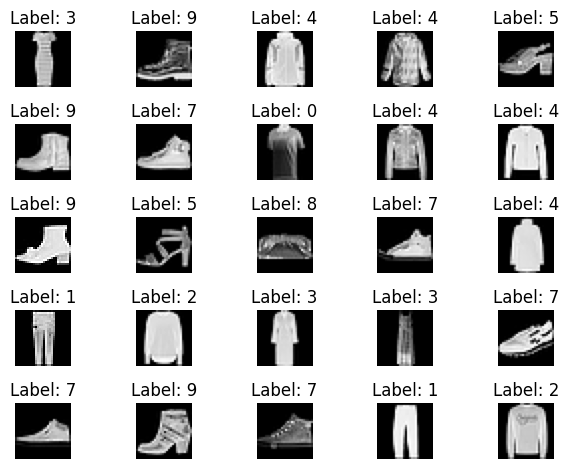

In [26]:
ae_train_data_sample = ae_train_data.sample(25)

ae_images = ae_train_data_sample.drop('label', axis=1).values
ae_labels = ae_train_data_sample['label'].values
ae_labels = ae_labels

ae_images = ae_images.reshape(-1, 28, 28)

ae_images = [Image.fromarray((image).astype(np.uint8)) for image in ae_images]

fig, axes = plt.subplots(5, 5)

for i, ax in enumerate(axes.flat):
    ax.imshow(ae_images[i], cmap='gray')
    ax.set_title(f"Label: {ae_labels[i]}")
    ax.axis('off')

plt.tight_layout()

In [27]:
class CnnAutoencoder(nn.Module):
    def __init__(self):
        super(CnnAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)


In [28]:
class MultiMNISTDataset_ae(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image.reshape(-1, 28, 28), dtype=torch.float32)
        return image, label

In [29]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
val_data_ae = MultiMNISTDataset_ae(ae_val_x, ae_val_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=True)
val_loader_ae = DataLoader(val_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

In [30]:
def train_autoencoder(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, _) in train_progress:
            x = x.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, x)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        val_loss = model.evaluate(val_loader, device)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.6f}")


In [31]:
autoencoder = CnnAutoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

train_autoencoder(autoencoder, optimizer, train_loader_ae, val_loader_ae, num_epochs=10)

Epoch 1/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 1563/1563 [00:10<00:00, 143.31it/s, Loss=0.0123]


Epoch 1, Validation Loss: 0.012753


Epoch 2/10: 100%|██████████| 1563/1563 [00:10<00:00, 156.12it/s, Loss=0.0105]


Epoch 2, Validation Loss: 0.009586


Epoch 3/10: 100%|██████████| 1563/1563 [00:09<00:00, 157.15it/s, Loss=0.0105]


Epoch 3, Validation Loss: 0.008301


Epoch 4/10: 100%|██████████| 1563/1563 [00:10<00:00, 155.96it/s, Loss=0.0073]


Epoch 4, Validation Loss: 0.007524


Epoch 5/10: 100%|██████████| 1563/1563 [00:09<00:00, 156.76it/s, Loss=0.0075]


Epoch 5, Validation Loss: 0.007063


Epoch 6/10: 100%|██████████| 1563/1563 [00:09<00:00, 157.09it/s, Loss=0.0069]


Epoch 6, Validation Loss: 0.006798


Epoch 7/10: 100%|██████████| 1563/1563 [00:10<00:00, 155.68it/s, Loss=0.0083]


Epoch 7, Validation Loss: 0.006592


Epoch 8/10: 100%|██████████| 1563/1563 [00:10<00:00, 156.00it/s, Loss=0.0045]


Epoch 8, Validation Loss: 0.006450


Epoch 9/10: 100%|██████████| 1563/1563 [00:09<00:00, 157.23it/s, Loss=0.0056]


Epoch 9, Validation Loss: 0.006318


Epoch 10/10: 100%|██████████| 1563/1563 [00:10<00:00, 155.22it/s, Loss=0.0055]


Epoch 10, Validation Loss: 0.006182


In [32]:
def plot_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            y_pred = model(x)
            break

    x = x.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.subplots_adjust(hspace=0.4)
    for i in range(10):
        axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(y_pred[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[0, i].set_title("Original")
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


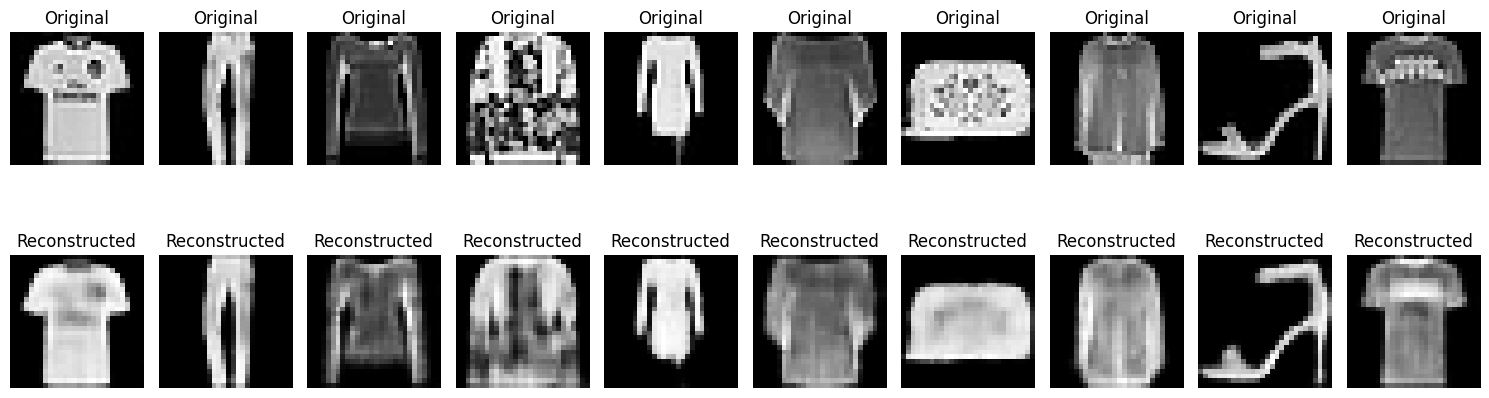

In [33]:
plot_reconstruction(autoencoder, test_loader_ae)

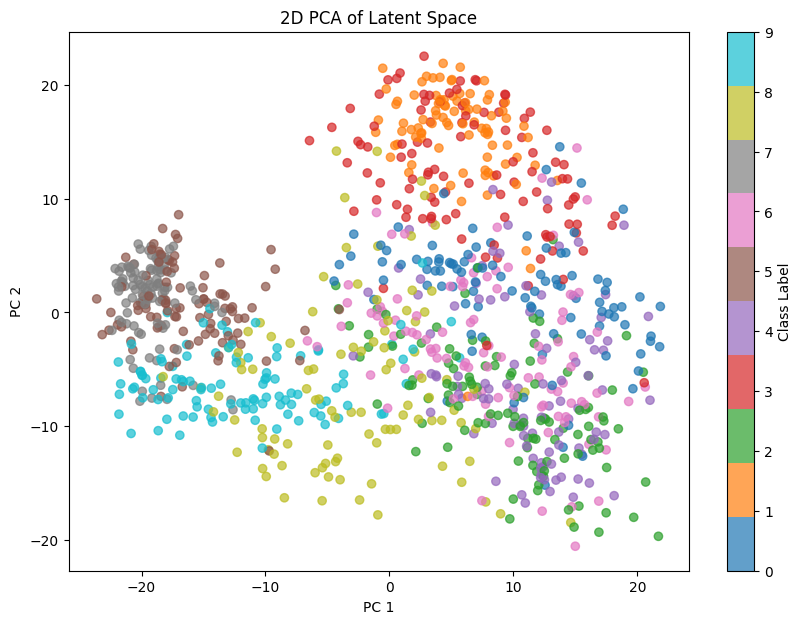

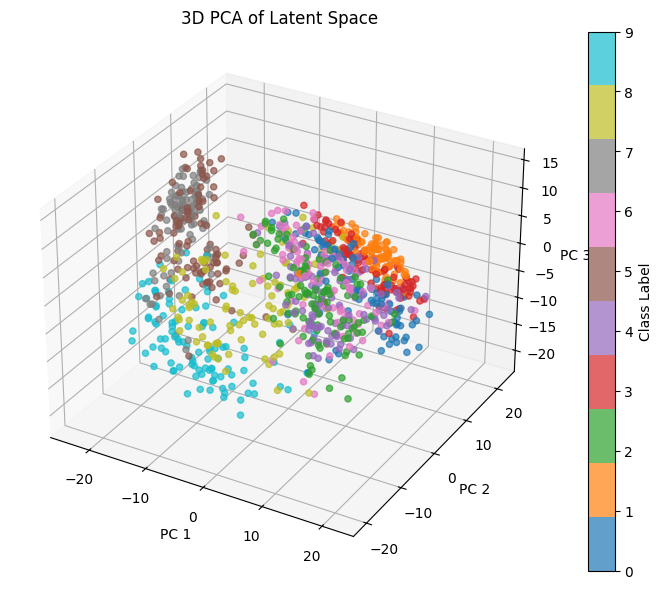

In [34]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    # 2D plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(autoencoder, test_loader_ae)


### MLP AutoEncoder

In [35]:
import sys
sys.path.append('./../../')

In [36]:
from models.autoencoder.autoencoder import AutoEncoder

input_dim = ae_train_x.shape[1]
latent_dim = 64
neurons_per_layer = [128] 
mlp_autoencoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, 
                              neurons_per_layer=neurons_per_layer, learning_rate=0.001, 
                              n_epochs=50, batch_size=32)

mlp_autoencoder.fit(ae_train_x)

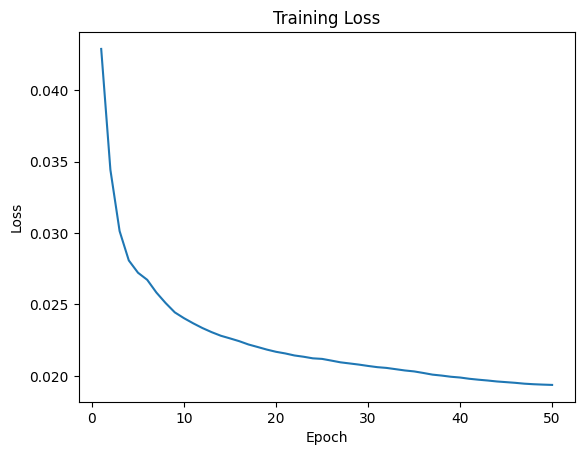

In [37]:
epochs = range(1, mlp_autoencoder.autoencoder.n_epochs + 1)
plt.plot(epochs, mlp_autoencoder.autoencoder.loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

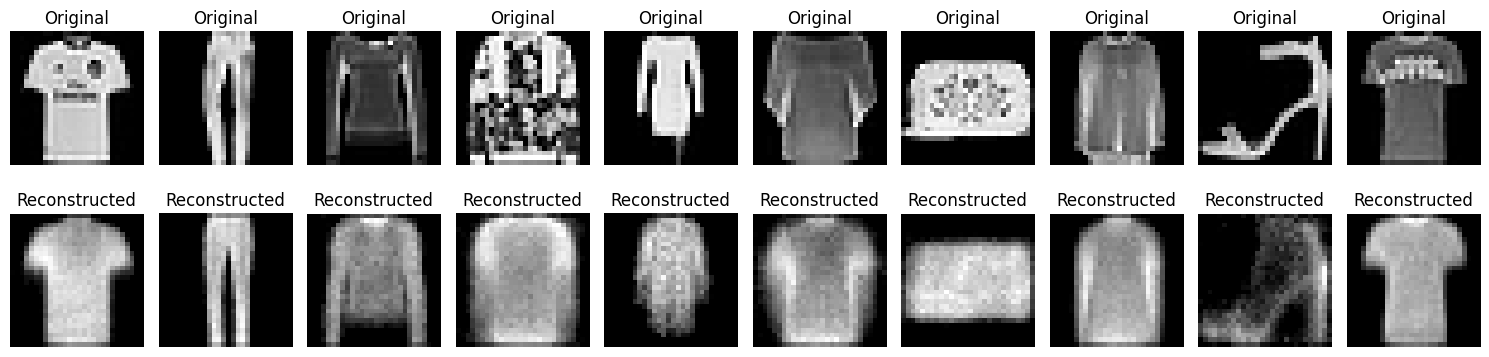

In [38]:
test_reconstructions = mlp_autoencoder.reconstruct(ae_test_x[:10])

original_images = ae_test_x[:10].reshape(-1, 28, 28)
reconstructed_images = test_reconstructions.reshape(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


In [39]:
from models.pca.pca import PCA

class PCA_autoencoder:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.pca = PCA(latent_dim)
    
    def fit(self, x):
        self.pca.fit(x)

    def encode(self, x):
        return self.pca.transform(x)

    def forward(self, x):
        x_encoded = self.encode(x)
        return np.dot(x_encoded, self.pca.eig_vectors[:, :self.latent_dim].T) + self.pca.means

In [40]:
def estimate_optimal_components(X_train, X_val, max_components=100):
    mse_errors = []
    component_range = range(1, max_components + 1)

    for n_components in component_range:
        pca_autoencoder = PCA_autoencoder(latent_dim=n_components)
        pca_autoencoder.fit(X_train)
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        mse = np.mean((X_val - X_val_reconstructed) ** 2)
        mse_errors.append(mse)

    plt.plot(component_range, mse_errors)
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot of Reconstruction Error vs Number of Components")
    plt.show()

    k_optimal = component_range[np.argmin(np.gradient(np.gradient(mse_errors)))]
    print(f"Optimal number of components (koptimal): {k_optimal}")

    return k_optimal, mse_errors

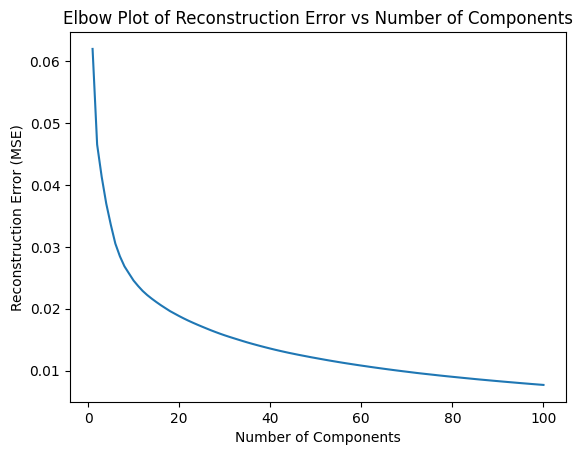

Optimal number of components (koptimal): 75


In [41]:
k_optimal, mse_errors = estimate_optimal_components(ae_train_x, ae_val_x, max_components=100)

In [42]:
def visualize_reconstructions(pca_autoencoder, X_test, num_images=10):
    X_reconstructed = pca_autoencoder.forward(X_test)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

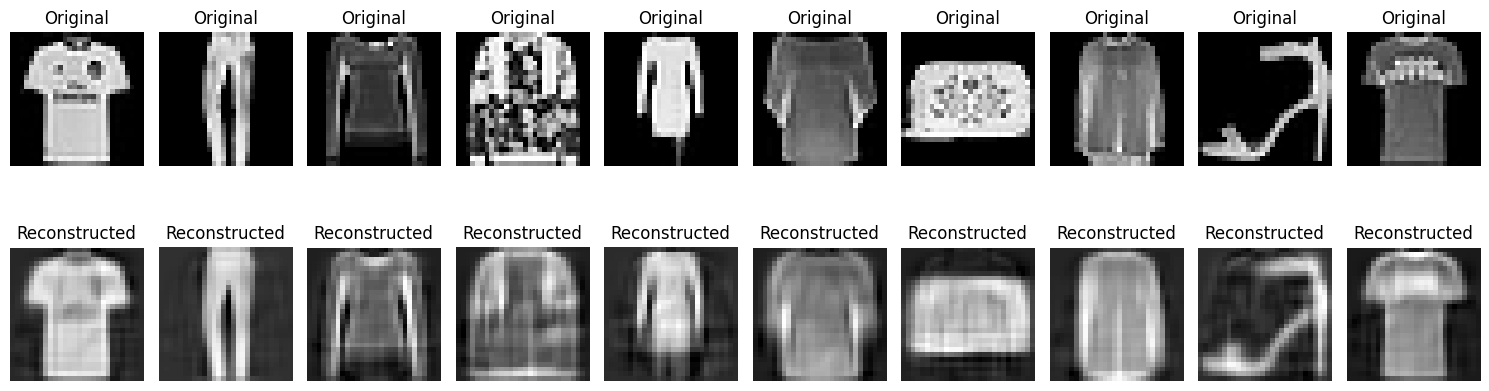

In [43]:
pca_autoencoder = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder.fit(ae_train_x)

visualize_reconstructions(pca_autoencoder, ae_test_x[:10])

### KNN Classification

In [44]:
ae_train_x_encoded_mlp = mlp_autoencoder.get_latent(ae_train_x)
ae_test_x_encoded_mlp = mlp_autoencoder.get_latent(ae_test_x)

In [45]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

ae_train_x_encoded_cnn = []
ae_test_x_encoded_cnn = []

autoencoder.eval()
with torch.no_grad():
    for x, _ in train_loader_ae:
        x = x.to(device)
        encoded = autoencoder.encode(x)
        ae_train_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

    for x, _ in test_loader_ae:
        x = x.to(device)
        encoded = autoencoder.encode(x)
        ae_test_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

ae_train_x_encoded_cnn = np.concatenate(ae_train_x_encoded_cnn)
ae_test_x_encoded_cnn = np.concatenate(ae_test_x_encoded_cnn)

In [46]:
pca_autoencoder_knn = PCA_autoencoder(latent_dim=64)
pca_autoencoder_knn.fit(ae_train_x)

In [47]:
ae_train_x_encoded_pca = pca_autoencoder_knn.encode(ae_train_x)
ae_test_x_encoded_pca = pca_autoencoder_knn.encode(ae_test_x)

In [48]:
from models.knn.knn import KNN
from performance_measures.knn_score import Scores

In [49]:
knn_k = 5

In [50]:
knn_cnn = KNN(k=knn_k)
knn_cnn.fit(ae_train_x_encoded_cnn, ae_train_y)
ae_pred_cnn = knn_cnn.predict(ae_test_x_encoded_cnn, distance_metric='cosine')
scores_cnn = Scores(ae_test_y, ae_pred_cnn)
accuracy_cnn = scores_cnn.accuracy
print(f"Accuracy of KNN with CNN Autoencoder: {accuracy_cnn:.2f}")

Accuracy of KNN with CNN Autoencoder: 0.88


In [51]:
knn_mlp = KNN(k=knn_k)
knn_mlp.fit(ae_train_x_encoded_mlp, ae_train_y)
ae_pred_mlp = knn_mlp.predict(ae_test_x_encoded_mlp, distance_metric='cosine')
scores_mlp = Scores(ae_test_y, ae_pred_mlp)
accuracy_mlp = scores_mlp.accuracy
print(f"Accuracy of KNN with MLP Autoencoder: {accuracy_mlp:.2f}")

Accuracy of KNN with MLP Autoencoder: 0.84


In [52]:
knn_pca = KNN(k=knn_k)
knn_pca.fit(ae_train_x_encoded_pca, ae_train_y)
ae_pred_pca = knn_pca.predict(ae_test_x_encoded_pca, distance_metric='cosine')
scores_pca = Scores(ae_test_y, ae_pred_pca)
accuracy_pca = scores_pca.accuracy
print(f"Accuracy of KNN with PCA: {accuracy_pca:.2f}")

Accuracy of KNN with PCA: 0.86


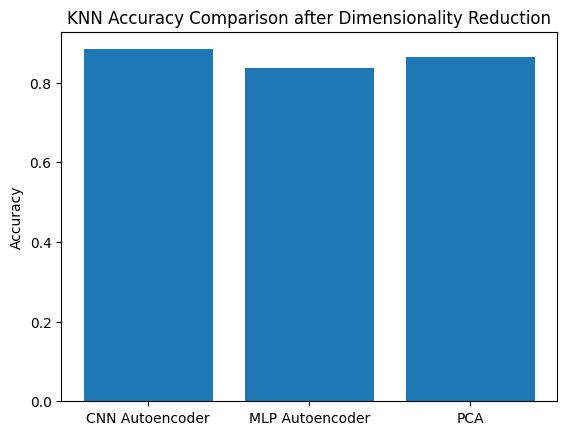

In [53]:
accuracies = [accuracy_cnn, accuracy_mlp, accuracy_pca]
labels = ['CNN Autoencoder', 'MLP Autoencoder', 'PCA']

plt.bar(labels, accuracies)
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Comparison after Dimensionality Reduction')
plt.show()

In [54]:
confusion_matrix_cnn = scores_cnn.confusion_matrix
confusion_matrix_mlp = scores_mlp.confusion_matrix
confusion_matrix_pca = scores_pca.confusion_matrix

confusion_matrix_cnn = confusion_matrix_cnn.astype(np.int32)
confusion_matrix_mlp = confusion_matrix_mlp.astype(np.int32)
confusion_matrix_pca = confusion_matrix_pca.astype(np.int32)

In [55]:
import seaborn as sns

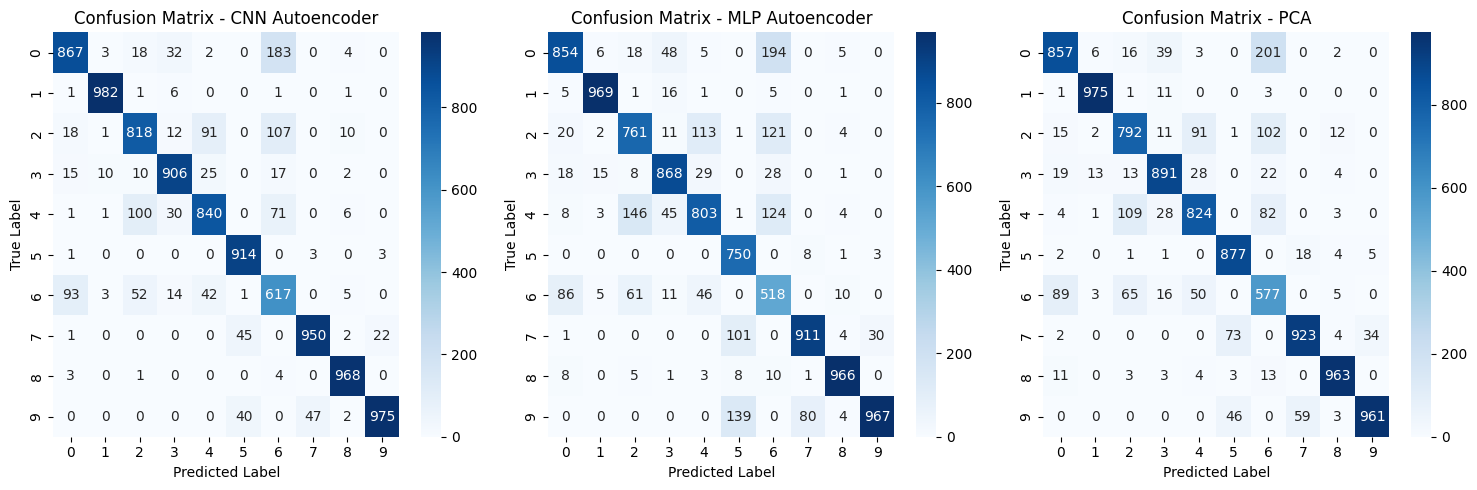

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN Autoencoder')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(confusion_matrix_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - MLP Autoencoder')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')


sns.heatmap(confusion_matrix_pca, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - PCA')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()